## Summary

This notebook covers my model built on my preprocessed data. I am running separate models to tune parameters and hyperparameters for Lasso and XGB models, and then I will implement stacking in the next step to improve the performance.

In [1]:
import numpy as np
import pandas as pd
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from math import sqrt
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, metrics
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

%matplotlib inline

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load datasets
with open('./house_price_clean.pickle', 'rb') as f:
        datasets = pickle.load(f)
        
x_train = datasets['train_dataset']
x_train.drop("Id", 1,inplace=True)
x_test = datasets['test_dataset']
x_test.drop("Id", 1,inplace=True)
y = datasets['train_labels']
names = list(x_train)

Lasso: I am running LassoCV model to obtain the optimum alpha that returns minimum CV error.

('alpha Value that Minimizes CV Error  ', 0.0005323864094544734)
('Minimum MSE  ', 0.011754077304076042)
('Minimum RMSE  ', 0.10841622251340452)


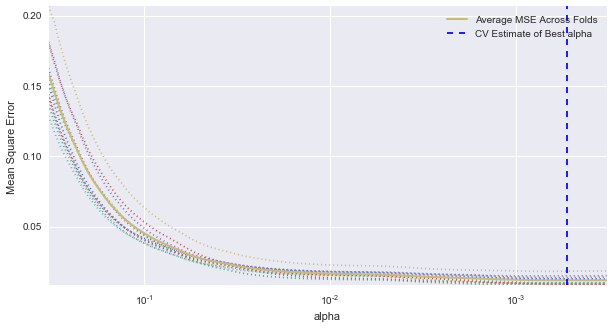

In [3]:
house_price_model = LassoCV(cv=10).fit(x_train, y)
plt.figure(figsize=(10,5))
plt.plot(house_price_model.alphas_, house_price_model.mse_path_, ':')
plt.plot(house_price_model.alphas_, house_price_model.mse_path_.mean(axis=-1),
          label='Average MSE Across Folds', linewidth=2)
plt.axvline(house_price_model.alpha_, linestyle='--',
             label='CV Estimate of Best alpha')
plt.semilogx()
plt.legend()
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('Mean Square Error')
plt.axis('tight')
#print out the value of alpha that minimizes the Cv-error
print("alpha Value that Minimizes CV Error  ",house_price_model.alpha_)
print("Minimum MSE  ", min(house_price_model.mse_path_.mean(axis=-1)))
print("Minimum RMSE  ", (min(house_price_model.mse_path_.mean(axis=-1)))**0.5)

('Attributes Ordered by How Early They Enter the Model', ['Utilities_AllPub', 'Street_Pave', 'Condition2_Norm', 'Heating_GasA', 'CentralAir_Y', 'GarageCond_TA', 'PavedDrive_Y', 'OverallQual', 'Electrical_SBrkr', 'GrLivArea', 'Functional_Typ', 'MSZoning_RL', '1stFlrSF', 'GarageCars', 'LotArea', 'Condition1_Norm', 'BsmtCond_TA', 'ExterCond_TA', 'OpenPorchSF', 'YearRemodAdd', 'BsmtFullBath', 'Fireplaces', 'HeatingQC_Ex', 'ScreenPorch', 'BsmtFinType1_GLQ', 'BuildingAge', 'BldgType_1Fam', 'BsmtFinSF1', 'BsmtHalfBath', 'BsmtFinSF2', 'OverallCond', 'LotShape_IR1', 'MasVnrArea', 'MoSold'])


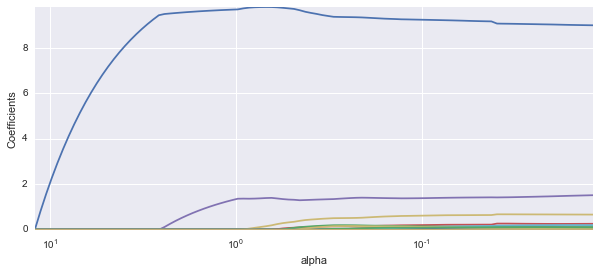

In [4]:
alphas, coefs, _  = linear_model.lasso_path(x_train, y,  return_models=False)
plt.figure(figsize=(10,4))
plt.plot(alphas,coefs.T)
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.axis('tight')
plt.semilogx()
ax = plt.gca()
ax.invert_xaxis()

nattr, nalpha = coefs.shape
#find coefficient ordering
nzList = []
for iAlpha in range(1,nalpha):
    coefList = list(coefs[: ,iAlpha])
    nzCoef = [index for index in range(nattr) if coefList[index] != 0.0]
    for q in nzCoef:
        if not(q in nzList):
            nzList.append(q)
nameList = [names[nzList[i]] for i in range(len(nzList))]
print("Attributes Ordered by How Early They Enter the Model", nameList)

In [5]:
#find coefficients corresponding to best alpha value. alpha value
# corresponding to normalized X and normalized Y is 0.0018272700877279638
alpha_star = min(house_price_model.mse_path_.mean(axis=-1))

index_alpha_star = [index for index in range(100) if alphas[index] >
alpha_star]
index_star = max(index_alpha_star)
#here's the set of coefficients to deploy
coef_star = list(coefs[:,index_star])
#print("Best Coefficient Values ", coefStar)
#The coefficients on normalized attributes give another slightly different ordering
abs_coef = [abs(a) for a in coef_star]
#sort by magnitude
coef_sorted = sorted(abs_coef, reverse=True)
idx_coef_size = [abs_coef.index(a) for a in coef_sorted if not(a == 0.0)]
names_list2 = [names[idx_coef_size[i]] for i in range(len(idx_coef_size))]
print("Attributes Ordered by Coef Size at Optimum alpha", names_list2)

('Attributes Ordered by Coef Size at Optimum alpha', ['Utilities_AllPub', 'Street_Pave', 'Condition2_Norm', 'Heating_GasA', 'Functional_Typ', 'GrLivArea', 'PavedDrive_Y', 'OverallQual', 'CentralAir_Y', 'BsmtCond_TA', 'BsmtFinType1_GLQ', 'LotArea', 'GarageCond_TA', 'Condition1_Norm', '1stFlrSF', 'GarageCars', 'ExterCond_TA', 'ScreenPorch', 'BuildingAge', 'HeatingQC_Ex', 'OverallCond', 'LotShape_IR1', 'OpenPorchSF', 'BsmtFullBath', 'Fireplaces', 'BsmtHalfBath', 'BsmtFinSF2', 'MSZoning_RL', 'YearRemodAdd', 'BldgType_1Fam', 'MoSold', 'MasVnrArea'])


XGB

In [8]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 150),
    "max_depth": [1,3, 7,8,12],
    "learning_rate": st.uniform(0.05, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 0.5),
    'reg_alpha': from_zero_positive,
    "min_child_weight": st.randint(3, 12),
}
xgbreg = XGBRegressor(
#                       "seed": 0, 
#                       "silent": 1,
#                       "objective": 'reg:linear', 
#                       "num_parallel_tree": 1,
#                       "eval_metric": 'rmse',
) 

from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

n_iter_search = 20         
gs.fit(x_train, y)  
report(gs.cv_results_)

Model with rank: 1
Mean validation score: 0.871 (std: 0.011)
Parameters: {'reg_alpha': 3.1116107998540308, 'colsample_bytree': 0.88296289182183862, 'learning_rate': 0.14322492029932765, 'min_child_weight': 9, 'n_estimators': 65, 'subsample': 0.99113798185538959, 'max_depth': 3, 'gamma': 0.16641549319124072}

Model with rank: 2
Mean validation score: 0.758 (std: 0.009)
Parameters: {'reg_alpha': 13.754115568431114, 'colsample_bytree': 0.98422036362342913, 'learning_rate': 0.072121812773159238, 'min_child_weight': 8, 'n_estimators': 76, 'subsample': 0.91832392018575748, 'max_depth': 7, 'gamma': 0.19615947003272971}

Model with rank: 3
Mean validation score: 0.700 (std: 0.006)
Parameters: {'reg_alpha': 30.662525818657059, 'colsample_bytree': 0.85558221134918988, 'learning_rate': 0.13838186377211653, 'min_child_weight': 3, 'n_estimators': 48, 'subsample': 0.7771613532341608, 'max_depth': 3, 'gamma': 0.38685520285143193}



In [9]:
def modelfit(model, x_train, x_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y.values)
        xgtest = xgb.DMatrix(x_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    model.fit(x_train, y,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = model.predict(x_train)
        
    #Print model report:
    print "\nModel Report"
    print "MSE : %.4g" % metrics.mean_squared_error(y.values, dtrain_predictions)
    print "RMSE : %f" % metrics.mean_squared_error(y.values, dtrain_predictions)**0.5
    
               
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)[0:50]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
MSE : 0.009102
RMSE : 0.095404


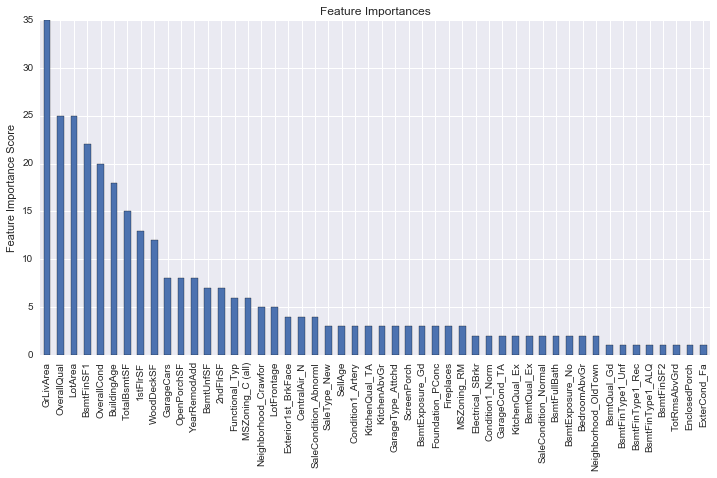

In [11]:
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
rcParams['figure.figsize'] = 12, 6


xgb1 = XGBRegressor(
        learning_rate =0.15,
        n_estimators=65,
        max_depth=3,
        min_child_weight=9,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.9,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        seed=0)
modelfit(xgb1, x_train, x_test)
